In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import loompy
import velocyto as vcy
import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
import cytograph as cg
import loompy
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
from tqdm import trange
from types import SimpleNamespace
import pandas as pd
from typing import *
from sklearn.preprocessing import scale
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

2018-12-24 14:02:12,487 INFO: ERROR: failed to import igraph; some clustering methods will not work
/Users/stelin/anaconda53/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
2018-12-24 14:02:15,519 DEBUG: backend module://ipykernel.pylab.backend_inline version unknown


In [10]:

class PerceptronModel(nn.Module):
    def __init__(self, n_inputs: int, n_outputs: int, lr: float = 0.01, l1_weight: float = 0.1, n_hidden: int = 0) -> None:
        super(PerceptronModel, self).__init__()

        if n_hidden == 0:
            n_hidden = n_inputs

        # Parameters
        self.l1_weight = l1_weight

        # The neural network
        self.layer1 = nn.Linear(n_inputs, n_hidden)
        self.activation1 = nn.Sigmoid()
        self.layer2 = nn.Linear(n_hidden, n_outputs)

        # The optimization algorithm
        self.optimiser = torch.optim.SGD(self.parameters(), lr = lr)

    def loss(self, y, y_pred):
        l1_reg = Variable(torch.FloatTensor(1), requires_grad=True)
        for W in self.parameters():
            l1_reg = l1_reg + W.norm(1)
        return nn.MSELoss()(y, y_pred) + self.l1_weight * l1_reg

    def forward(self, x):
        h = self.activation1(self.layer1(x))
        y = self.layer2(h)
        return y


class L1RegressionModel(nn.Module):
    def __init__(self, n_inputs: int, n_outputs: int, lr: float = 0.01, l1_weight: float = 0.1) -> None:
        super(L1RegressionModel, self).__init__()

        # Parameters
        self.l1_weight = l1_weight

        # The neural network
        self.layer1 = nn.Linear(n_inputs, n_outputs)
        
        # The optimization algorithm
        self.optimiser = torch.optim.SGD(self.parameters(), lr = lr)

    def loss(self, y, y_pred):
        l1_reg = Variable(torch.FloatTensor(1), requires_grad=True)
        for W in self.parameters():
            l1_reg = l1_reg + W.norm(1)
        return nn.MSELoss()(y, y_pred) + self.l1_weight * l1_reg

    def forward(self, x):
        y = self.layer1(x)
        return y


class LinearRegressionModel(nn.Module):
    def __init__(self, n_inputs: int, n_outputs: int, lr: float = 0.0001) -> None:
        super(LinearRegressionModel, self).__init__()

        # The neural network
        self.layer1 = nn.Linear(n_inputs, n_outputs)

        # The optimization algorithm
        self.optimiser = torch.optim.SGD(self.parameters(), lr = lr)

    def loss(self, y, y_pred):
        return nn.MSELoss()(y, y_pred)

    def forward(self, x):
        y = self.layer1(x)
        return y

class WaddingtonianDataset:
    def __init__(self, ds: loompy.LoomConnection) -> None:
        human_TFs = pd.read_csv("/Users/stelin/code/development-human/TFs_human.txt", sep="\t").values.T[0]
        self.n_cells = ds.shape[1]
        self.regulators = (np.isin(ds.ra.Gene, human_TFs)) #& (ds.ra.Selected == 1))
        self.regulator_names = ds.ra.Gene[self.regulators]
        self.n_regulators = self.regulators.sum()
        self.targets = ds.ra.Selected == 1
        self.target_names = ds.ra.Gene[self.targets]
        self.n_targets = self.targets.sum()

        # Load the velocity data for all selected genes
        v_data = np.empty((self.n_targets, self.n_cells), dtype='float32')
        r = 0
        for (_, _, view) in ds.scan(items=self.targets, axis=0, layers=["pooled"]):
            v_data[r:r + view.shape[0], :] = view.layers["pooled"][:, :]
            r += view.shape[0]
        self.v = torch.from_numpy(v_data.T)

        # Load the expression data for TFs only
        s_data = np.empty((self.n_regulators, self.n_cells), dtype='float32')
        r = 0
        for (_, _, view) in ds.scan(items=self.regulators, axis=0, layers=["pooled"]):
            s_data[r:r + view.shape[0], :] = view.layers["pooled"][:, :]
            r += view.shape[0]
        self.s = torch.from_numpy(s_data.T)
        
class WaddingtonianInference:
    def __init__(self, dataset: WaddingtonianDataset, model_type: nn.Module = LinearRegressionModel, lr: float = 0.001, n_epochs: int = 100, **kwargs) -> None:
        self.dataset = dataset
        self.model_type = model_type
        self.model: nn.Module = None
        self.model_kwargs = kwargs
        self.lr = lr
        self.n_epochs = n_epochs
        self.losses: List[float] = []
        self.mse: List[float] = []

    def fit(self) -> None:
        self.model = self.model_type(self.dataset.n_regulators, self.dataset.n_targets, self.lr, **self.model_kwargs)

        t = trange(self.n_epochs)
        for epoch in t:
            self.model.optimiser.zero_grad()

            x = Variable(self.dataset.s)
            y = Variable(self.dataset.v)

            y_pred = self.model.forward(x)
            loss = self.model.loss(y, y_pred)
            mse = torch.sum(torch.pow(y - y_pred, 2))
            self.losses.append(float(loss))
            self.mse.append(float(mse))
            loss.backward()
            self.model.optimiser.step()
            t.set_description(f"loss={int(loss)}, mse={int(mse)}")
            t.refresh()

In [11]:
f = "/Users/stelin/build_20181213/L2_Cerebellum_Excitatory.loom"
with loompy.connect(f) as ds:
    wdata = WaddingtonianDataset(ds)

In [12]:
wi = WaddingtonianInference(wdata, model_type=LinearRegressionModel, lr=0.00000000001, n_epochs=500)
wi.fit()

loss=643441408, mse=643441408: 100%|██████████| 500/500 [01:22<00:00,  6.09it/s]


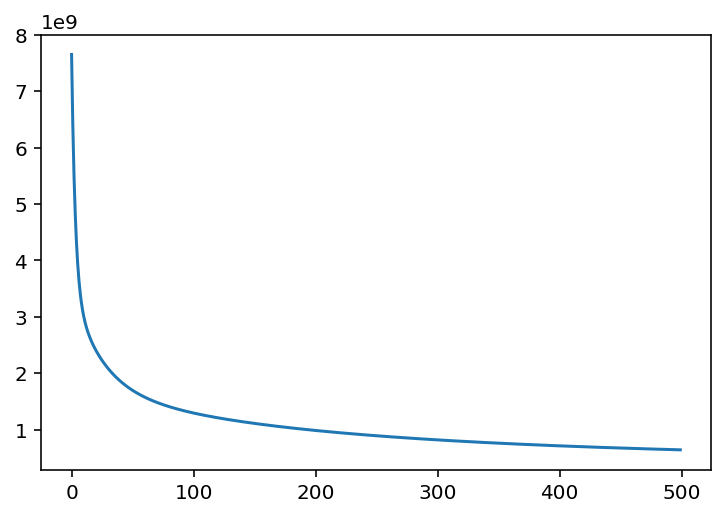

In [13]:
_=plt.plot(np.arange(len(wi.losses)), wi.mse)

In [7]:
np.sort(wdata.regulator_names[np.argsort(np.max(wi.model.layer1.weight.detach().numpy(), axis=0))[-70:]])

array(['ADNP', 'ARID1B', 'ARID4A', 'BARHL1', 'BCL11A', 'CAMTA1',
       'CARHSP1', 'CERS6', 'DACH1', 'DRAP1', 'EBF2', 'ENO1', 'ESRRG',
       'EVX1', 'FOXP2', 'GABPB1', 'HES1', 'HES4', 'HEY1', 'ID1', 'ID2',
       'ID3', 'ID4', 'INSM1', 'JARID2', 'JUN', 'LHX1', 'LHX9', 'MAF1',
       'MATR3', 'MBD5', 'MEIS1', 'MLLT11', 'MLLT3', 'NEUROD2', 'NHLH1',
       'NHLH2', 'NPAS3', 'NR2F1', 'NR2F2', 'PAX5', 'PBX1', 'PBX3',
       'PHF5A', 'RERE', 'RFX4', 'RUNX1T1', 'SETBP1', 'SKIL', 'SMARCA4',
       'SMARCC2', 'SOX2', 'ST18', 'TCF12', 'TCF25', 'TCF4', 'TFAP2B',
       'TSC22D1', 'TSHZ2', 'YBX1', 'ZCCHC11', 'ZEB1', 'ZFHX3', 'ZFP36L1',
       'ZNF428', 'ZNF462', 'ZNF536', 'ZNF652', 'ZNF804A', 'ZNF83'],
      dtype=object)

['THSD7A' 'DLL3' 'NFIB' 'GCK' 'PTCHD2' 'SST' 'RP11-708B6.2' 'HNF1A-AS1'
 'ISL1' 'DAPL1']


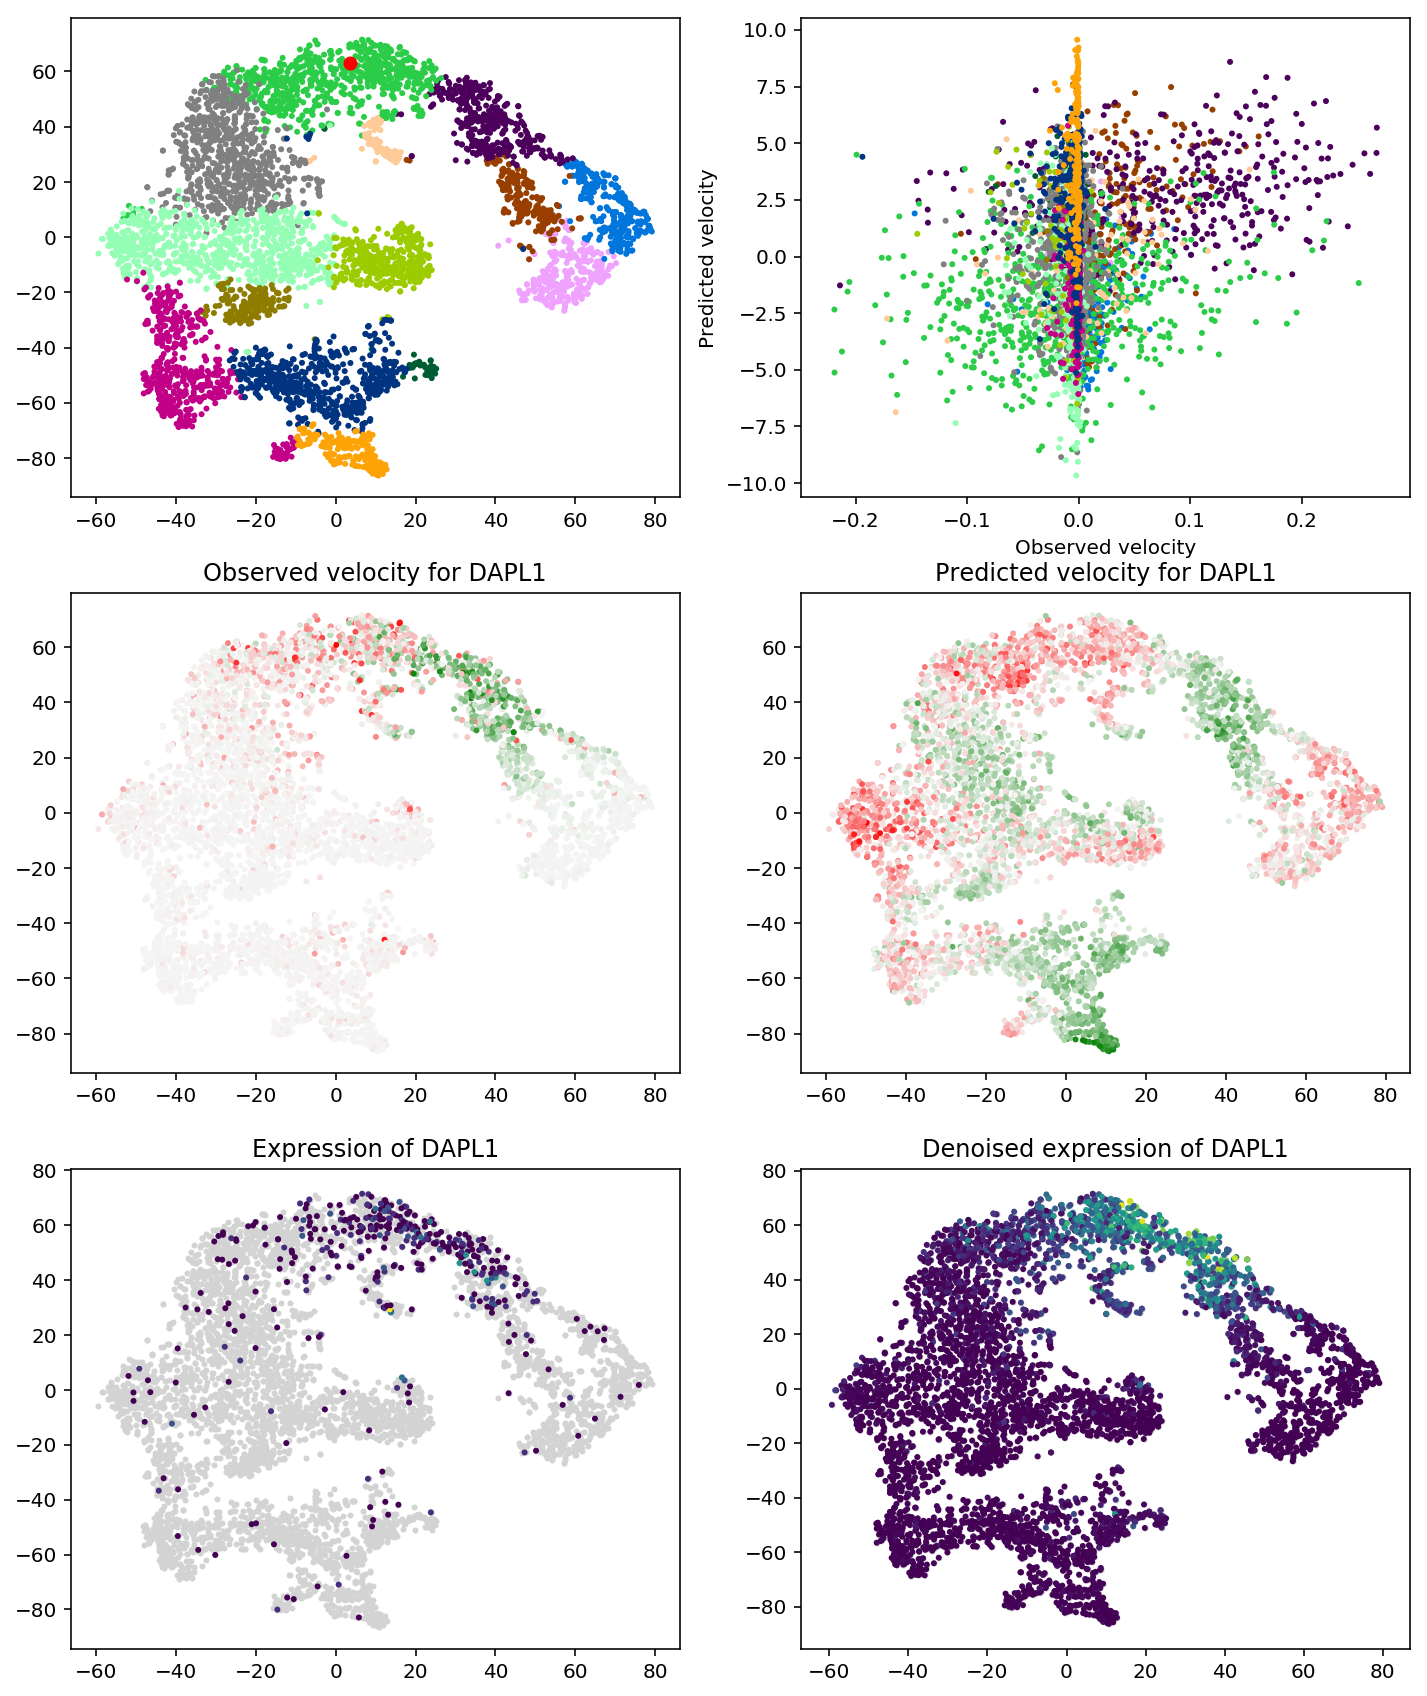

In [9]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
norm1 = MidpointNormalize(midpoint=0)
norm2 = MidpointNormalize(midpoint=0)
vcmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","whitesmoke","green"])


with loompy.connect(f) as ds:
    ix = 1901
    plt.figure(figsize=(12,15))
    plt.subplot(321)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c=cg.colorize(ds.ca.Clusters), marker='.',lw=0)
    plt.plot(ds.ca.TSNE[ix,0], ds.ca.TSNE[ix,1],c='red',marker='o')
    plt.subplot(322)
    s = wdata.s.detach().numpy()
    v = wdata.v.detach().numpy()
    y_pred = wi.model.forward(Variable(wdata.s)).detach().numpy()

    top_idx = -1
    #top = np.where(wdata.target_names == "AFF3")[0][0]
    top = np.argsort(v[ix, :])[top_idx]

    plt.scatter(v[:, top],y_pred[:, top],c=cg.colorize(ds.ca.Clusters), marker='.',lw=0)
    plt.xlabel("Observed velocity")
    plt.ylabel("Predicted velocity")
    print(wdata.target_names[np.argsort(v[ix, :])[-10:]])
    
    plt.subplot(323)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c=v[:, top], norm=norm1, cmap=vcmap, marker='.',lw=0)
    plt.title("Observed velocity for " + wdata.target_names[top])
        
    plt.subplot(324)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c=y_pred[:, top], norm=norm2, cmap=vcmap, marker='.',lw=0)
    plt.title("Predicted velocity for " + wdata.target_names[top])

    plt.subplot(325)
    x = ds[ds.ra.Gene == wdata.target_names[top], :][0]
    cells = x > 0
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c='lightgrey', marker='.',lw=0)
    plt.scatter(ds.ca.TSNE[cells,0], ds.ca.TSNE[cells,1],c=x[cells], marker='.',lw=0)
    plt.title("Expression of " + wdata.target_names[top])

    plt.subplot(326)
    x = ds["spliced_exp"][ds.ra.Gene == wdata.target_names[top], :][0]
    cells = x > 0
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c='lightgrey', marker='.',lw=0)
    plt.scatter(ds.ca.TSNE[cells,0], ds.ca.TSNE[cells,1],c=x[cells], marker='.',lw=0)
    plt.title("Denoised expression of " + wdata.target_names[top])




In [11]:
v.shape,s.shape

((5517, 509), (5517, 72))

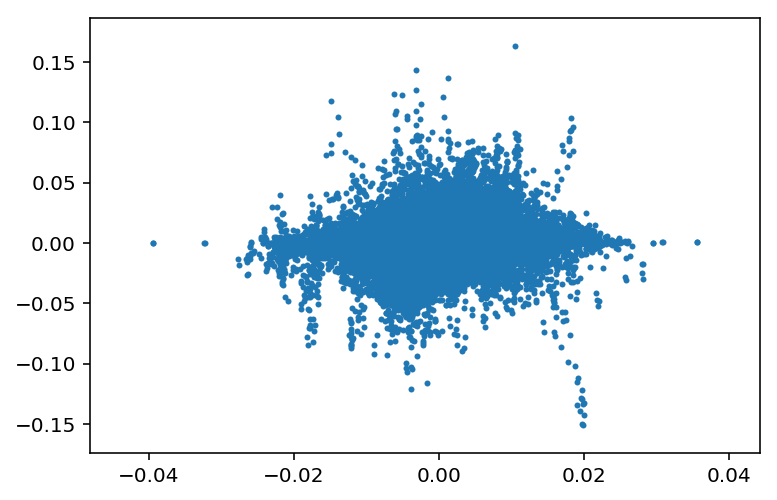

In [44]:
_=plt.scatter(y_pred[:100,:].ravel(),v[:100,:].ravel(),lw=0,marker='.')

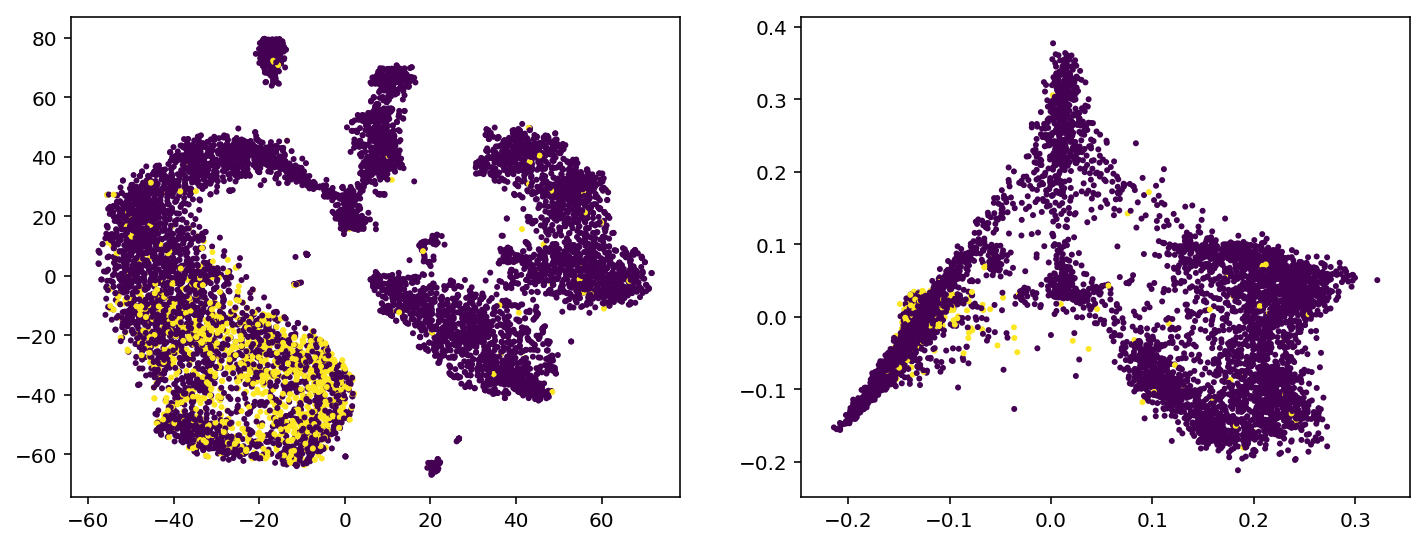

In [218]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Cortex_11w.loom") as ds:
    pca = PCA(n_components=5).fit_transform(ds.ca.HPF)
    plt.figure(figsize=(12,15))
    plt.subplot(321)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c=ds[ds.ra.Gene == "GRIK3", :][0] > 0, marker='.',lw=0)
    plt.subplot(322)
    plt.scatter(pca[:,0], pca[:,3],c=ds[ds.ra.Gene == "GRIK3", :][0] > 0, marker='.',lw=0)

In [348]:
from numba import jit
@jit(nopython=True)
def gaussian_gradient(v: np.ndarray, x: np.ndarray) -> np.ndarray:
    n = len(v)
    a = np.exp(0.5 * np.sum(-(np.power(x, 2) / v)))
    b = np.power(2, n / 2) * np.sqrt(v.prod()) * np.power(np.pi, n / 2)
    return -(a / b) * (x / v)

@jit(nopython=True)
def apply_gaussian_gradient(s: np.ndarray, sigma2: np.ndarray, pos: np.ndarray):
    (n_cells, n_dims) = pos.shape
    gs = np.zeros((n_cells, n_dims))
    for i in range(n_cells):
        for j in range(n_cells):
            gs[i, :] += s[j] * gaussian_gradient(sigma2, pos[j, :] - pos[i, :])
    return gs

In [349]:
gaussian_gradient(np.array([1,1,1]), np.array([2, 1, 1.5]))

array([-0.0033841 , -0.00169205, -0.00253807])

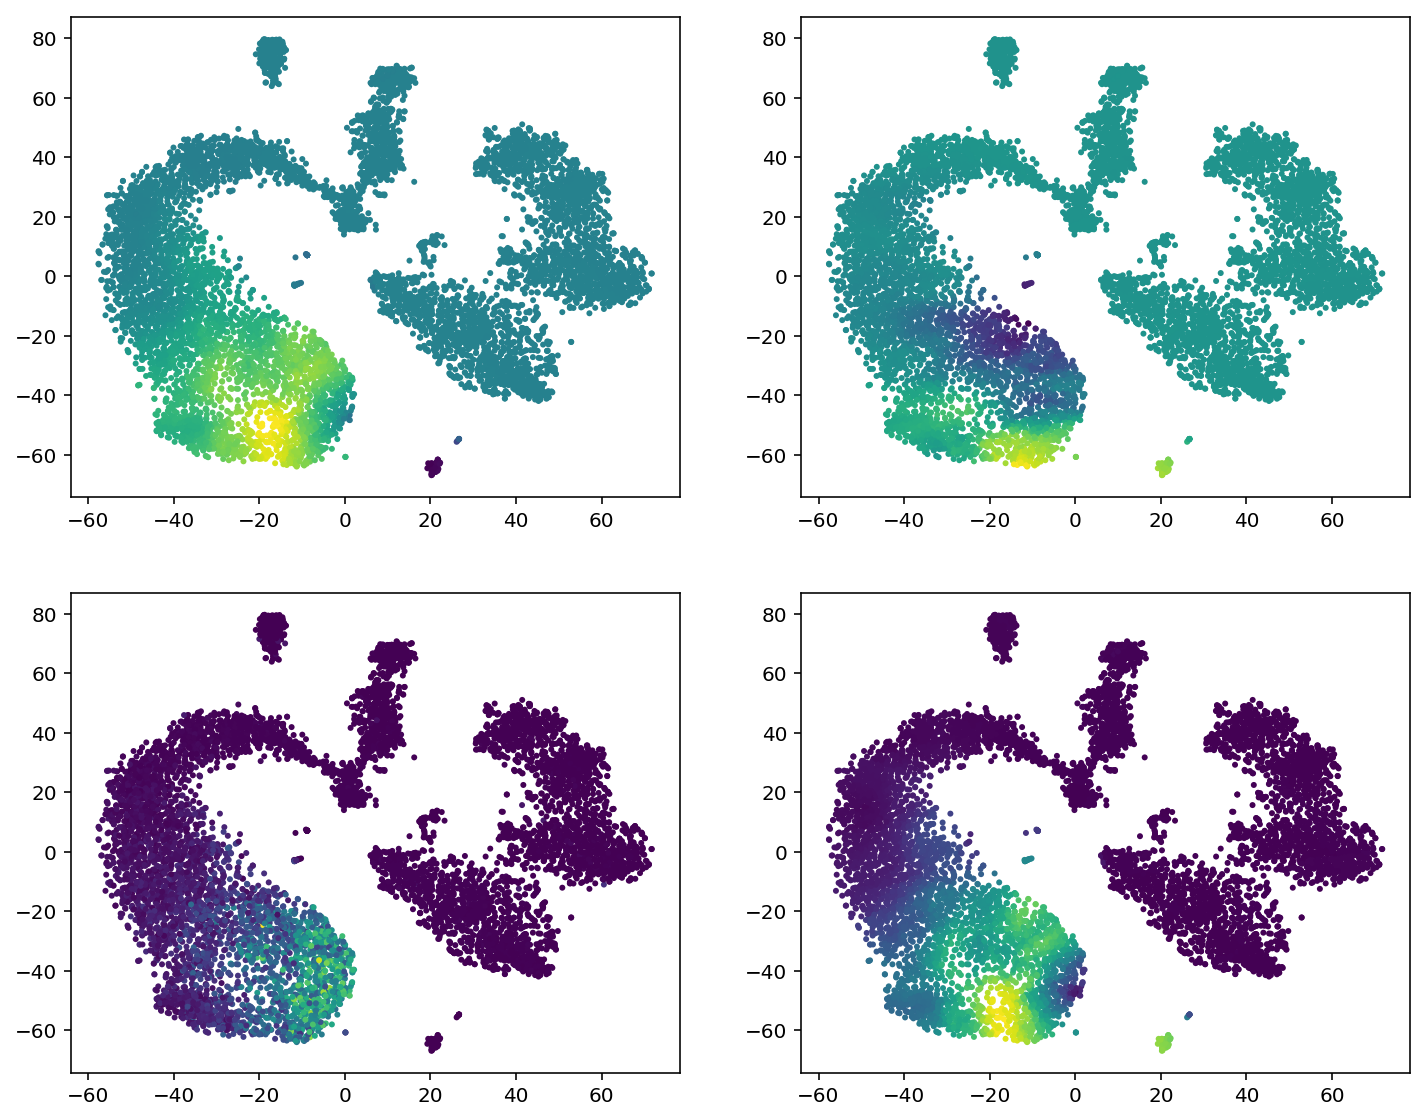

In [374]:
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
with loompy.connect("/Users/stelin/dh_20170213/L1_Cortex_11w.loom") as ds:
    n_cells = ds.shape[1]
    s = ds["spliced_exp"][ds.ra.Gene == "GRIK3", :][0]
    v = ds["velocity"][ds.ra.Gene == "GRIK3", :][0]
    pos = ds.ca.TSNE
    n_dims = pos.shape[1]
    neigh = NearestNeighbors(n_neighbors=400, algorithm="ball_tree", n_jobs=4)
    neigh.fit(pos)
    knn = neigh.kneighbors(return_distance=False)
    gx = np.zeros((n_cells, n_dims))
    for i in range(n_cells):
        y = s[knn[i, :]]
        X = pos[knn[i, :]]
        lr = LinearRegression()
        lr.fit(X, y)
        gx[i, :] = lr.coef_
    plt.figure(figsize=(12,15))
    plt.subplot(321)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c=gx[:,0], marker='.',lw=0)
    plt.subplot(322)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c=gx[:,1], marker='.',lw=0)
    plt.subplot(323)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c=s, marker='.',lw=0)
    plt.subplot(324)
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1],c=LA.norm(gx, axis=1), marker='.',lw=0)

In [369]:
%%time
y = s[knn[0, :]]
X = pos[knn[0, :]]
lr = LinearRegression()
lr.fit(X, y)
lr.coef_

CPU times: user 678 µs, sys: 150 µs, total: 828 µs
Wall time: 729 µs


In [34]:
import subprocess
import fcntl
import os

class InteractiveProcess:
    def __init__(self, cmd):
        self.process = subprocess.Popen(
            cmd,
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        fd = self.process.stdout.fileno()
        flag = fcntl.fcntl(fd, fcntl.F_GETFL)
        fcntl.fcntl(fd, fcntl.F_SETFL, flag | os.O_NONBLOCK)

    def read(self):
        return self.process.stdout.readline().decode("utf-8").strip()


    def write(self, message):
        self.process.stdin.write(f"{message.strip()}\n".encode("utf-8"))
        self.process.stdin.flush()

    def terminate(self):
        self.process.stdin.close()
        self.process.terminate()
        self.process.wait(timeout=0.2)

process = InteractiveProcess(["ssh", "sten@monod.mbb.ki.se"])


In [35]:
process.write("i")

In [38]:
process.read()

''

In [298]:
process.write("jupyter lab --no-browser --port 9327")

In [31]:
process.process.communicate()

KeyboardInterrupt: 

In [236]:
process.stdout.readable()

True

In [229]:
process.communicate()

ValueError: Invalid file object: <_io.BufferedReader name=77>

In [454]:
class MemoryUsage:
    def __init__(self) -> None:
        self.prev_mem = 0
        self.mem = 0
        self.usage()

    def usage(self) -> Tuple[float, float]:
        # return the memory usage in MB
        process = psutil.Process(os.getpid())
        self.prev_mem = self.mem
        self.mem = process.memory_info()[0] / float(2 ** 20)
        return f"{self.mem}, Δ={self.mem - self.prev_mem}"

In [455]:
memory = MemoryUsage()

In [458]:
memory.usage()

'971.9765625, Δ=0.00390625'

In [27]:
from pynndescent import NNDescent
import scipy.sparse as sparse
data = np.random.uniform(size=(100,200))
index = NNDescent(data)
indices, distances = index.query(data, k=15)
#indices = indices[1:, :]
#distances = distances[1:, :]
knn = sparse.csr_matrix(
    (np.ravel(distances), np.ravel(indices), np.arange(0, distances.shape[0] * distances.shape[1] + 1, distances.shape[1])), (data.shape[0], data.shape[0])
)

In [30]:
indices

array([[ 0, 30, 77, ..., 72, 15, 48],
       [ 1, 57, 64, ..., 89, 97, 98],
       [ 2, 91, 57, ..., 19, 11, 70],
       ...,
       [97, 57, 61, ..., 30, 39, 53],
       [98, 56, 47, ..., 50, 91, 14],
       [99, 31, 10, ..., 11, 93, 27]])

In [53]:
knn

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 1400 stored elements in Compressed Sparse Row format>